# Sina's Wieners
### A Discrete Time Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modsim import *
import pandas as pd
from datetime import date, timedelta
from scipy import stats
import seaborn as sns

sns.set()
plt.style.use('dark_background')

### Generate 10k Customers

Attributes:

* Salary
* Cash
* Credit
* Affinity
* Willingness

The amount of money each is given will be based on an estimated average/mean salary for 2020.  We do not have complete information from later years.  The mean was \$53,383, and the median \$34,612.  Theoretically, half of the people should have a salary below the median, and the median and mean should line up.  In reality, this figure is highly skewed:

!["Source: https://www.ssa.gov/OACT/COLA/central.html"](wages.png)

Over time, the pay of management has risen far faster than the pay of "regular" employees.  So, for this experiment, we will assume that the hyper rich don't care for hotdogs, and that the median salary is the most realistic for the most people.  Median household salary for 2020 was around \$67,000 according to the US Census, and the poverty line for a 3-person household was \$21,700 according to the department of Health and Human Services.

For simplicity, we will assume salaries for individual customers of Sina's Wieners to be normally distributed, centered around \$35,000, with a standard deviation of \$14,000.  We know that reality is much messier than this, but we have to start somewhere.



Cash and credit will initialize at zero.

The affinity score will range from 0 to 1, again normally distributed around the center of the range.

Finally, we have willingness to download and use the app.  This value is either a 0 or 1.  From 1 January, 10% of the population will be ready to try it.  Whenever somebody makes a purchase with credit rewards, they will tell 3 friends about it, and each will have a 50% chance of downloading the app. 1 will be a regular customer, and 2 will be outside customers.

In [2]:
def generate_customer() -> tuple:
    """
    Generate a customer with some randomly given attributes.
    Returns: Tuple with customer attributes.
    """

    # Salary normally distributed around 35k
    salary = np.random.normal(loc=35000, scale=14000)

    # Affinity for the wieners normally distributed around 1/2
    affinity = np.random.normal(loc = 0.5, scale = 0.1)

    cash = 0
    credit = 0
    willingness = 0

    return (salary, cash, credit, affinity, willingness)
    
customers = pd.DataFrame(columns=['salary', 'cash', 'credit',
                                  'affinity', 'willingness'])

for i in range(10000):
    customers.loc[i] = generate_customer()

Now, we must give these people some cash to eat hotdogs with for the first 2-week period.  They will get paid on the 1st and 15th of each month, which means this number will be replenished.  The cash will not carry over, but the credit will.

Their hotdog money is equal to 5% of the pay received in a pay period.

We must also select the people who feel like trying out the app.

In [3]:
customers.cash = 0.05 * customers.salary / 26
users = customers.sample(frac = 0.1)
users.willingness = 1
customers.update(users)

customers = customers.round(decimals=2)
customers.head(10)

,salary,cash,credit,affinity,willingness
0,9194.55,17.68,0.0,0.50,0.0
1,42976.30,82.65,0.0,0.46,0.0
2,22806.41,43.86,0.0,0.52,0.0
3,44546.96,85.67,0.0,0.67,0.0
4,57749.76,111.06,0.0,0.52,0.0
5,12872.37,24.75,0.0,0.40,0.0
6,45967.30,88.40,0.0,0.47,0.0
7,46076.07,88.61,0.0,0.64,0.0
8,41144.33,79.12,0.0,0.55,0.0
9,30555.71,58.76,0.0,0.48,0.0


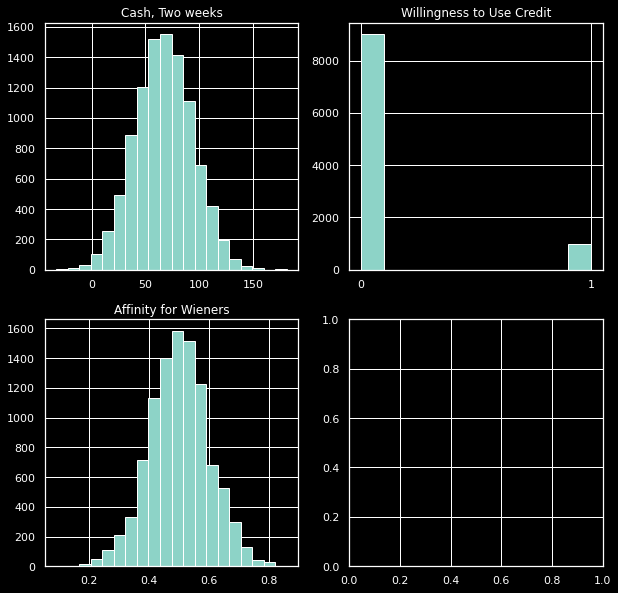

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax[0,0].hist(customers.cash, bins=20)
ax[0,0].set_title('Cash, Two weeks')

ax[0,1].hist(customers.willingness, bins=10)
ax[0,1].set_title('Willingness to Use Credit')
ax[0,1].xaxis.set_ticks([0,1])

ax[1,0].hist(customers.affinity, bins=20)
ax[1,0].set_title('Affinity for Wieners')

plt.show()

### Federal Holidays

No business will be conducted on these days

In [5]:
holidays = (date(2020, 1, 1), date(2020, 1, 20),
            date(2020, 2, 17),
            date(2020, 5, 25),
            date(2020, 7, 4),
            date(2020, 9, 7),
            date(2020, 11, 11), date(2020, 11, 26),
            date(2020, 12, 24), date(2020, 12, 25))

### Average Daily Customers

In 2019, Burger King had around 18,000 restaurant locations around the world, serving 11 million customers per day.  We will use this information for our average daily customer rate of = 612.

source: https://expandedramblings.com/index.php/burger-king-statistics-facts/

The hottest day of the year in 2020 was July 21.  This was 202 days away from the beginning of the year.  We will use this information to model the customers coming in each day.  The coldest day was January 17th... and without putting in this information, we hit very close with a normal cosine oscillation.

<AxesSubplot:>

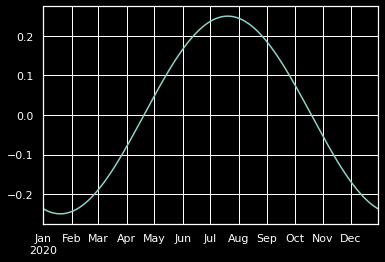

In [6]:
df = pd.DataFrame(index=pd.date_range(start='2020-01-01', end='2020-12-31', freq='D'))
factor = 0.25
df['y'] = np.cos((df.index.to_series().dt.day_of_year - 202)/365*2*np.pi) * factor
df['y'].plot()

### Define Initial Parameters

* Date begins at Jan 1
* Start in Winter
* Include all customers (don't modify the original dataframe)
* Include holidays
* Real money spent begins at 0
* Rewards spent begins at 0
* Good experience rate 99.5%
* Customer reward rate 10%
* Customers can buy in discrete denominations of $8 - $32, counting by $4

In [7]:
params = Params(
    customers = customers,
    holidays = holidays,
    exp_rate = 0.995,
    reward = 0.1,
    menu = (8, 12, 16, 20, 24, 28, 32)
    )

def make_system(params):
    """
    Make a system with the given parameters.
    Returns: System object.
    """
    init = State(
        customers = params.customers,
        day = date(2020, 1, 1),
        buyers = None,
        capacity = 0.06125,
        history = [])
    
    return System(params, state = init)

system = make_system(params)

In [8]:
def turnout(day):
    """
    Calculate the customer turnout for a given day.
    Returns: int.
    """
    day = day.strftime('%Y-%m-%d')
    df = pd.DataFrame(index=pd.date_range(start='2020-01-01', end='2020-12-31', freq='D'))
    factor = 0.25
    df['y'] = np.cos((df.index.to_series().dt.day_of_year - 202)/365*2*np.pi) * (1 + factor)
    n = df['y'].loc[day] + 1 * np.random.normal(loc=len(system.state.customers), scale=50) * system.state.capacity
    return int(n)

### Start Day

* If the day is 1 or 15, wipe the cash, and refill the amount.
* Choose customers based on:
    * cash and credit available
    * affinity
    * restaurant average daily numbers

In [9]:
def start_day(system):
    """
    Start a day in the system.
    Returns: System object.
    """
    
    # Potential customers are those who have cash or credit,
    # and who don't hate the restaurant.
    cash_buyers = system.state.customers[system.state.customers['cash'] >= 8]
    credit_buyers = system.state.customers[system.state.customers['credit'] >= 8]

    buyers = cash_buyers.merge(credit_buyers, how='outer')
    buyers = buyers[buyers['affinity'] > 0.05]

    # Customers are selected at random near the average daily total
    n = int(np.random.normal(loc=turnout(system.state.day) + system.state.capacity, scale=50))

    # Higher turnout in Summer
    n = turnout(system.state.day)
    
    system.state.buyers = buyers.sample(n)

    return system

### User Aqcuisition

Whenever a person makes a successful purchase with credit:
* They tell three friends about the service
    * 1 is already a customer
    * 2 are potential new customers
* Each has a 50% of downloading and using the rewards service
    * People who are not already customers will start enjoying the restaurant when they begin using the rewards program

In [10]:
def word_of_mouth(system):
    """
    On credit purchases, customers will spread the good word.
    Returns: System object.
    """
    if flip(0.33):
        oldie = system.state.customers[system.state.customers['willingness'] == 0].sample(1)
        oldie['willingness'] = 1
        system.state.customers.update(oldie)

    if flip(0.33):
        i = len(system.state.customers) + 1
        system.state.customers.loc[i] = generate_customer()
        system.state.customers.loc[i]['willingness'] = 1
    
    return system

### Conduct Business

* Selected customers make purchases
    * purchases are either cash or credit, not both
    * after credit purchase, 3 friends are told about the app.  Each has a 50% chance of becoming a user.
    * purchases are always in discrete amounts
* Rewards issued to "willing" customers
* Experience is good/bad
* History saved
    * number of customers
    * total purchases cash
    * total purchases credit
    * total credit issued

In [11]:
def conduct_business(system):
    """
    Makes sales for a day and issue credit accordingly.
    Returns: System object.
    """

    # For the history matrix... day, number of customers,
    # credit purchases, cash purchases, credit issued.
    today = [system.state.day,
             len(system.state.buyers),
             None, None, None]

    for i in system.state.buyers.index:        
        # For each person, choose an item to buy.
        # If it is too expensive, the person buys the cheapest item.
        person = system.state.buyers.loc[i]
        
        item = np.random.choice(params.menu)
        if (item > person.cash) & (item > person.credit):
            item = 8

        # Buying with credit
        if (item <= person.credit):
            person.credit -= item
            if today[2] == None:
                today[2] = item
            else:
                today[2] += item
            
            # This cutomer spreads the good word
            system = word_of_mouth(system)

        # Buying with cash
        elif (item <= person.cash):
            person.cash -= item
            if today[3] == None:
                today[3] = item
            else:
                today[3] += item

            # Issue credit
            if person.willingness == 1:
                person.credit += item * params.reward
                if today[4] == None:
                    today[4] = person.credit
                else:
                    today[4] += person.credit
         
        # Punish negative dining experience, slightly reward a positive one
        if flip(params.exp_rate):
            person.affinity *= 1.1
        else:
            person.affinity *= 0.75

        # Update customer information
        system.state.customers.loc[i].update(person)

    # Update history
    if system.state.history:
        system.state.history.append(today)
    else:
        system.state.history = [today]

    return system

### After Hours Trading

* Trade or keep assets from the day, based on affinity score
* Trades subtract credit from seller
* Trades add 80% cash to seller
* Trades add credit to buyer
* Trades subtract 80% cash from buyer


In [12]:
def trade_rewards(system):
    """
    Dissatisfied customers trade credit for 80% cash.
    Returns: System object.
    """
    
    users = system.state.customers[system.state.customers['willingness'] != 0]
    dissatisfied = users[users.affinity < 0.05]
    satisfied = users[users.affinity >= 0.05]

    # Loop through dissatisfied customers
    for i in dissatisfied.index:
        seller = dissatisfied.loc[i]
        if satisfied.cash.sum() < seller.credit:
            break
        
        # Trade until credit is gone
        while person.credit > 0:
            # Find a random buyer and trade
            buyer = satisfied.sample(1)
            credit_swap = min(seller.credit, buyer.cash * 0.8)
            seller.credit -= credit_swap
            buyer.credit += credit_swap
            buyer.cash -= credit_swap * 0.8
            seller.cash += credit_swap * 0.8

    system.state.customers.update(users)
    return(system)

### End Day

* If day is Dec 31, terminate simulation
* Start Spring Mar 20
* Start Summer Jun 21
* Start Autumn Sep 23
* Start Winter Dec 21

In [13]:
def end_day(system):
    """
    End a day in the system.
    Return: system object.
    """
    # Pay day!
    if system.state.day == (1 | 15):
        system.state.customers.cash = 0.05 * system.state.customers.salary / 26
    
    # Update season
    if system.state.day == date(2020, 3, 19):
        system.state.season = 'spring'
    elif system.state.day == date(2020, 6, 20):
        system.state.season = 'summer'
    elif system.state.day == date(2020, 9, 22):
        system.state.season = 'fall'
    elif system.state.day == date(2020, 12, 20):
        system.state.season = 'winter'
    
    # Update day
    system.state.day += timedelta(days=1)
    
    return system

### Run Simulation

* start_day()
* if day is holiday skip to end_day()
* conduct_business()
* after_hours()
* end_day()
* return system object

In [14]:
def run_simulation(system):
    """
    Run the simulation.
    Returns: System object.
    """
    while system.state.day < date(2020, 12, 31):
        system = start_day(system)

        # Nobody works on federal holidays!
        if system.state.day in params.holidays:
            system = end_day(system)

        # This is a normal day
        else:
            system = conduct_business(system)
            system = trade_rewards(system)
            system = end_day(system)
            
    return system

In [15]:
final = run_simulation(system)
history = pd.DataFrame(final.state.history,
    columns=['day', 'customers', 'credit_purchases', 'cash_purchases', 'credit_issued'])

### Descriptive Graphs

Total spent each day

Rewards used vs traded over all

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(10,10))

ax[0,0].plot(history.day, history.customers)
ax[0,0].set_title('Customers')

ax[0,1].plot(history.day, history.credit_purchases)
ax[0,1].set_title('Credit Purchases')

ax[1,0].plot(history.day, history.cash_purchases)
ax[1,0].set_title('Cash Purchases')

ax[1,1].plot(history.day, history.credit_issued)
ax[1,1].set_title('Credit Issued')

### Cost/Benefit Analysis

What is the net profit with these parameters?

In [ ]:
def net_profit(system):
    """
    Returns: net profit.
    Each purchase costs the business $0.40 to produce for each $1 purchased
    """
    revenue = history.cash_purchases.sum()
    net = revenue - (history.credit_purchases.sum() + history.credit_purchases.sum()) * 0.6
    return net

net_profit(history)

What is the optimal reward rate?

In [ ]:
reward_array = linspace(0.01, 0.2, 11)
reward_array

In [ ]:
def sweep_rewards(reward_array, params):
    """
    Sweeps a range of values for customer rewards.
    Returns: Sweep object
    """
    sweep = SweepSeries()
    for rate in reward_array:
        params.reward = rate
        system = make_system(params)
        final = run_simulation(system)
        history = pd.DataFrame(final.state.history,
            columns=['day', 'customers', 'credit_purchases',
                     'cash_purchases', 'credit_issued'])
        sweep[rate] = net_profit(history)

    return sweep


In [ ]:
reward_sweep = sweep_rewards(reward_array, params)